In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 4 — Supervised Learning Basics
## Lesson 9: Multiclass Logistic Regression (Softmax) and Evaluation



### What you will learn in this lesson

By the end of this lesson, you will be able to:

- Explain **multiclass logistic regression** as a probabilistic linear classifier with a **softmax** output layer.
- Derive (at a practitioner level) the **cross-entropy / negative log-likelihood** objective and its gradient.
- Implement **numerically stable softmax**, **log-softmax**, and **multinomial log-loss** in Python.
- Train multiclass logistic regression using **scikit-learn** with correct **preprocessing pipelines** (scaling + one-hot encoding).
- Evaluate multiclass models using:
  - confusion matrices (raw and normalized),
  - macro / micro / weighted precision–recall–F1,
  - Top-$k$ accuracy,
  - multiclass ROC-AUC (OvR / OvO),
  - log-loss (a strictly proper scoring rule),
  - confidence/entropy-based diagnostics,
  - and cost-sensitive decisioning.

We will use multiple datasets from your repository to avoid building intuition around a single example:

- `iris.csv` (classic multiclass, all numeric)
- `drug200.csv` (mixed numeric + categorical, clear need for encoding)
- `stars.csv` (mixed types, useful for class imbalance and evaluation nuance)
- `glass.csv` (many classes + subtle separations; good for “macro vs accuracy” stress tests)

All dataset paths in code are relative to your repository structure (e.g., `../../../Datasets/...`).



### Prerequisites

You should be comfortable with:

- Binary logistic regression (sigmoid, odds, log-loss)
- Basic linear algebra (vectors, matrices, dot product)
- Train/validation/test splits and cross-validation
- Python with `pandas`, `numpy`, `matplotlib`, and `scikit-learn`

If you are rusty on binary logistic regression, revisit **Chapter 4 — Lesson 3** first.



### Why multiclass logistic regression matters (even if you plan to use “stronger” models later)

Multiclass logistic regression is one of the highest-leverage baselines in classical ML:

- It is **fast** to train and reasonably robust.
- It yields **probabilities** (not just labels), which makes it useful for ranking, triage, and downstream decisioning.
- Its objective (multiclass cross-entropy) is the same loss used in many neural networks; understanding it transfers directly.

A practical mindset:

- If a simple softmax model performs poorly, a more complex model may also fail unless the **data** and **features** improve.
- If the softmax model performs well and is well-calibrated, you may not need a more complex model at all.

In other words: softmax logistic regression is not a “toy”; it is a baseline you should take seriously.


In [2]:
# Core scientific stack
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Model + evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    log_loss,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    top_k_accuracy_score,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score
)

np.set_printoptions(precision=4, suppress=True)



## 1) Model definition: logits, softmax, and maximum likelihood

For multiclass classification with $K$ classes:

$$
z_k = \mathbf{w}_k^\top \mathbf{x} + b_k
$$

Softmax converts logits to probabilities:

$$
p(y=k\mid \mathbf{x})
= \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}
$$

Training is maximum likelihood, equivalent to minimizing multiclass cross-entropy.

A helpful loss identity is:

$$
\ell_i = - z_{i,y_i} + \log\left(\sum_{j=1}^K e^{z_{i,j}}\right)
$$

We will use this identity later to build a numerically stable implementation.

### Multinomial vs OvR (conceptual)

- **Multinomial (softmax)** learns all classes jointly and enforces $\sum_k p_k=1$.
- **OvR** learns $K$ independent binary models and can behave differently under imbalance.

### Geometry

Between classes $a$ and $b$, the decision boundary is a hyperplane:

$$
(\mathbf{w}_a-\mathbf{w}_b)^\top \mathbf{x} + (b_a-b_b) = 0
$$

So, in the feature space you provide, this is a linear classifier.



## 2) Derivation sketch: why the gradient becomes $(P - Y)$

Let $\mathbf{P}=\mathrm{softmax}(\mathbf{Z})$ be predicted probabilities and $\mathbf{Y}$ be one-hot labels.

Cross-entropy:

$$
\mathcal{L} = -\frac{1}{n}\sum_{i=1}^{n}\sum_{k=1}^{K} Y_{ik}\log P_{ik}
$$

Key identity:

$$
\frac{\partial \mathcal{L}}{\partial Z_{ik}} = \frac{1}{n}(P_{ik} - Y_{ik})
$$

Then:

$$
\nabla_{\mathbf{W}}\mathcal{L} = \frac{1}{n}\mathbf{X}^\top(\mathbf{P}-\mathbf{Y})
$$

Add L2 regularization $\frac{\lambda}{2}\|\mathbf{W}\|_F^2$:

$$
\nabla_{\mathbf{W}}\mathcal{L}_\lambda
= \frac{1}{n}\mathbf{X}^\top(\mathbf{P}-\mathbf{Y}) + \lambda \mathbf{W}
$$

Interpretation: the “error signal” is **predicted minus true**, and regularization shrinks weights.



## 3) Evaluation metrics deep dive (multiclass)

Multiclass evaluation is where many ML projects go wrong, because it is easy to:

- report a single number (accuracy) that looks good,
- while important classes are failing silently,
- or probabilities are badly miscalibrated, leading to risky decisions.

This section gives you a reference mental model for the most common multiclass metrics.

### 3.1 Confusion matrix

For $K$ classes, the confusion matrix $M\in\mathbb{R}^{K\times K}$ has entries:

- $M_{i,j}$ = number of samples with true class $i$ predicted as class $j$.

You should look for:

- large off-diagonal blocks (systematic class confusion),
- minority classes with very small diagonal entries (near-zero recall).

A row-normalized confusion matrix answers:  
“Given the true class, how does the model distribute predictions?”

### 3.2 Per-class precision, recall, and F1

For class $k$ (treating it as “positive” and all others as “negative”):

- True positives: $\mathrm{TP}_k = M_{k,k}$
- False negatives: $\mathrm{FN}_k = \sum_{j\neq k} M_{k,j}$
- False positives: $\mathrm{FP}_k = \sum_{i\neq k} M_{i,k}$

Then:

$$
\mathrm{Precision}_k = \frac{\mathrm{TP}_k}{\mathrm{TP}_k + \mathrm{FP}_k}
$$

$$
\mathrm{Recall}_k = \frac{\mathrm{TP}_k}{\mathrm{TP}_k + \mathrm{FN}_k}
$$

$$
\mathrm{F1}_k = \frac{2\,\mathrm{Precision}_k\,\mathrm{Recall}_k}{\mathrm{Precision}_k + \mathrm{Recall}_k}
$$

Interpretation:

- Precision answers: “When the model predicts class $k$, how often is it correct?”
- Recall answers: “Of all true class $k$, how many did we catch?”
- F1 balances precision and recall; it is harsh when either is low.

### 3.3 Macro / micro / weighted averages

Given per-class metrics, there are several averaging conventions:

- **Macro average**: treat all classes equally  
  $$\mathrm{MacroF1} = \frac{1}{K}\sum_{k=1}^K \mathrm{F1}_k$$  
  Best when each class matters equally, even rare ones.

- **Weighted average**: weight by support (class counts)  
  $$\mathrm{WeightedF1} = \sum_{k=1}^K w_k \mathrm{F1}_k,\quad w_k=\frac{n_k}{n}$$  
  Best when overall volume matters more.

- **Micro average**: aggregate TP/FP/FN across classes first, then compute the metric.  
  For single-label multiclass classification, micro-F1 equals accuracy.  
  This can hide minority failures.

### 3.4 Balanced accuracy

Balanced accuracy is the average of per-class recall:

$$
\mathrm{BalancedAcc} = \frac{1}{K}\sum_{k=1}^K \mathrm{Recall}_k
$$

It is a simple, strong default to accompany accuracy in imbalanced multiclass problems.

### 3.5 Top-$k$ accuracy

Top-$k$ accuracy counts a prediction as correct if the true class is among the top $k$ predicted probabilities.

This is relevant when:

- you can show multiple candidates to a user,
- or the system can defer to another process (human-in-the-loop).

### 3.6 Log-loss (cross-entropy) as probability evaluation

Accuracy and F1 evaluate **hard decisions**.  
Log-loss evaluates **probability quality**.

For one sample:

$$
\ell_i = -\log p(y_i\mid x_i)
$$

A model that is wrong with 0.99 confidence is punished much more than a model that is wrong with 0.40 confidence.

This is important because in many systems, probability influences:

- ranking,
- thresholding,
- cost-sensitive decisions,
- abstention policies.

If you treat probabilities as scores, you should report log-loss.



## 4) Why log-loss is different from accuracy (proper scoring rules)

Accuracy is a 0–1 loss:
- either you got the class right (1),
- or you did not (0).

It does not distinguish between:

- a correct prediction with 0.51 confidence and one with 0.99 confidence,
- a wrong prediction with 0.51 confidence and one with 0.99 confidence.

Log-loss (cross-entropy) *does* distinguish these cases, and that matters when probabilities drive decisions.

### 4.1 A concrete example

Suppose the true class is A.

- Model 1 predicts: A=0.51, B=0.49  
- Model 2 predicts: A=0.99, B=0.01  

Both have accuracy = 1 on this sample, but Model 2 has much lower log-loss.

Now suppose the model is wrong:

- Model 3 predicts: A=0.49, B=0.51  
- Model 4 predicts: A=0.01, B=0.99  

Both have accuracy = 0, but Model 4 is punished far more by log-loss (overconfident wrong).

This is why in risk-sensitive applications, a model with slightly lower accuracy but much better log-loss can be preferable.

### 4.2 Calibration vs discrimination

- **Discrimination**: can the model rank the correct class above others? (AUC-like thinking)
- **Calibration**: are predicted probabilities numerically meaningful?  
  If the model says “0.8”, is it correct about 80% of the time?

Multiclass logistic regression is often a solid baseline for calibration, but you should still validate it.
We will do a simple confidence-binning check later.



## 5) Numerical stability: stable softmax, log-softmax, and stable log-loss

Naively computing $\exp(z)$ can overflow.

Use:
- stable softmax by subtracting max logit,
- stable log-softmax via log-sum-exp.

Below we implement naive and stable variants.


In [3]:
def softmax_naive(Z, axis=1):
    Z = np.asarray(Z)
    expZ = np.exp(Z)
    return expZ / np.sum(expZ, axis=axis, keepdims=True)

def softmax_stable(Z, axis=1):
    Z = np.asarray(Z)
    Z_max = np.max(Z, axis=axis, keepdims=True)
    expZ = np.exp(Z - Z_max)
    return expZ / np.sum(expZ, axis=axis, keepdims=True)

def log_softmax_stable(Z, axis=1):
    Z = np.asarray(Z)
    Z_max = np.max(Z, axis=axis, keepdims=True)
    shifted = Z - Z_max
    logsumexp = Z_max + np.log(np.sum(np.exp(shifted), axis=axis, keepdims=True))
    return Z - logsumexp

Z_demo = np.array([[1.0, 2.0, 3.0],
                   [1000.0, 1001.0, 1002.0]])

print("Stable softmax:\n", softmax_stable(Z_demo, axis=1))
print("Naive softmax (may contain nan/inf):\n", softmax_naive(Z_demo, axis=1))


Stable softmax:
 [[0.09   0.2447 0.6652]
 [0.09   0.2447 0.6652]]
Naive softmax (may contain nan/inf):
 [[0.09   0.2447 0.6652]
 [   nan    nan    nan]]


C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_21612\1295893021.py:3: RuntimeWarning: overflow encountered in exp
  expZ = np.exp(Z)
C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_21612\1295893021.py:4: RuntimeWarning: invalid value encountered in divide
  return expZ / np.sum(expZ, axis=axis, keepdims=True)


In [4]:
def multiclass_log_loss(y_true, P_pred, eps=1e-15):
    y_true = np.asarray(y_true)
    P_pred = np.asarray(P_pred)
    P_pred = np.clip(P_pred, eps, 1 - eps)
    n = y_true.shape[0]
    return -np.mean(np.log(P_pred[np.arange(n), y_true]))

def multiclass_log_loss_from_logits(y_true, Z_logits):
    y_true = np.asarray(y_true)
    logP = log_softmax_stable(Z_logits, axis=1)
    return -np.mean(logP[np.arange(y_true.shape[0]), y_true])

from sklearn.metrics import log_loss as skl_log_loss

y_true_demo = np.array([0, 2])
P_pred_demo = np.array([[0.7, 0.2, 0.1],
                        [0.1, 0.2, 0.7]])
Z_logits_demo = np.log(P_pred_demo)

print("Custom (P):", multiclass_log_loss(y_true_demo, P_pred_demo))
print("Custom (logits):", multiclass_log_loss_from_logits(y_true_demo, Z_logits_demo))
print("sklearn:", skl_log_loss(y_true_demo, P_pred_demo, labels=[0,1,2]))


Custom (P): 0.35667494393873245
Custom (logits): 0.35667494393873245
sklearn: 0.35667494393873245



## 6) scikit-learn implementation notes (parameters you should know)

`sklearn.linear_model.LogisticRegression` is flexible, but a few parameters dominate outcomes:

- `solver`: `"lbfgs"` is a strong default for multinomial softmax on small/medium datasets.
- `penalty`: `"l2"` is default; L1/elasticnet require `saga`.
- `C`: inverse regularization; small `C` shrinks weights and can improve generalization but may underfit.
- `max_iter`: increase if you see convergence warnings.
- `class_weight`: use `"balanced"` when you care about minority classes and counts are skewed.

A good baseline for tabular data:

- standardize numeric features,
- one-hot encode categorical features,
- use `LogisticRegression(max_iter=5000, solver="lbfgs")`,
- report accuracy, macro-F1, and log-loss.

We will follow this pattern in the examples.



## 7) Preprocessing for softmax models: scaling and encoding

Feature scales matter for optimization and regularization.
For numeric data, standardization is typically beneficial.

For mixed data, always use a pipeline with:

- `StandardScaler` for numeric columns
- `OneHotEncoder(handle_unknown="ignore")` for categorical columns

We first show the effect of scaling on Iris.


In [5]:
df_iris = pd.read_csv("../../../Datasets/Classification/iris.csv")

X = df_iris.drop(columns=["classification"])
y = df_iris["classification"]

classes = sorted(y.unique())
class_to_id = {c:i for i,c in enumerate(classes)}
y_id = y.map(class_to_id).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y_id, test_size=0.25, random_state=42, stratify=y_id
)

clf_no_scale = LogisticRegression(max_iter=5000, solver="lbfgs")
clf_no_scale.fit(X_train, y_train)
P_no_scale = clf_no_scale.predict_proba(X_test)

pipe_scale = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, solver="lbfgs"))
])
pipe_scale.fit(X_train, y_train)
P_scale = pipe_scale.predict_proba(X_test)

print("No scaling — Log-loss:", log_loss(y_test, P_no_scale, labels=list(range(len(classes)))))
print("Scaling    — Log-loss:", log_loss(y_test, P_scale, labels=list(range(len(classes)))))


No scaling — Log-loss: 0.1745597185049716
Scaling    — Log-loss: 0.20998634709656164



## 8) Example A — Iris (numeric-only)

We will train a scaled softmax logistic regression and evaluate it.


In [6]:
display(df_iris.head())
print(df_iris.shape)
print(df_iris["classification"].value_counts())


,sepal_length,sepal_width,petal_length,petal_width,classification
0,5.4,3.7,1.5,0.2,Iris-setosa
1,4.8,3.4,1.6,0.2,Iris-setosa
2,4.8,3.0,1.4,0.1,Iris-setosa
3,4.3,3.0,1.1,0.1,Iris-setosa
4,5.8,4.0,1.2,0.2,Iris-setosa


(150, 5)
classification
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


In [7]:
pipe_iris = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, solver="lbfgs"))
])

pipe_iris.fit(X_train, y_train)

y_pred = pipe_iris.predict(X_test)
P_test = pipe_iris.predict_proba(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("Log-loss:", log_loss(y_test, P_test, labels=list(range(len(classes)))))


Accuracy: 0.9210526315789473
Balanced accuracy: 0.923076923076923
Macro F1: 0.9229629629629629
Log-loss: 0.20998634709656164


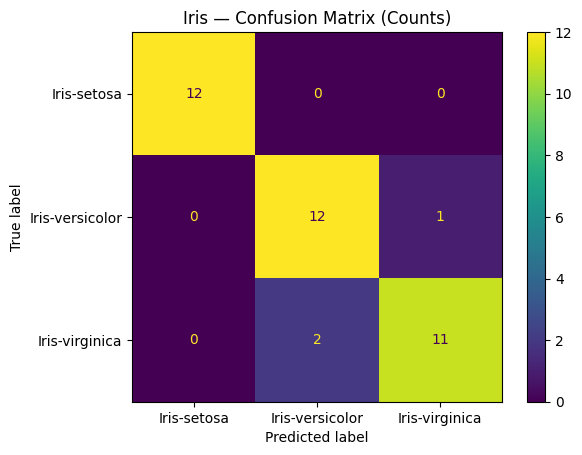

                 precision    recall  f1-score   support

    Iris-setosa     1.0000    1.0000    1.0000        12
Iris-versicolor     0.8571    0.9231    0.8889        13
 Iris-virginica     0.9167    0.8462    0.8800        13

       accuracy                         0.9211        38
      macro avg     0.9246    0.9231    0.9230        38
   weighted avg     0.9226    0.9211    0.9209        38



In [8]:
cm = confusion_matrix(y_test, y_pred, labels=list(range(len(classes))))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.title("Iris — Confusion Matrix (Counts)")
plt.show()

print(classification_report(y_test, y_pred, target_names=classes, digits=4))



### 8.1 Normalized confusion matrix

Row-normalized confusion matrix is excellent for diagnosing recall failures.


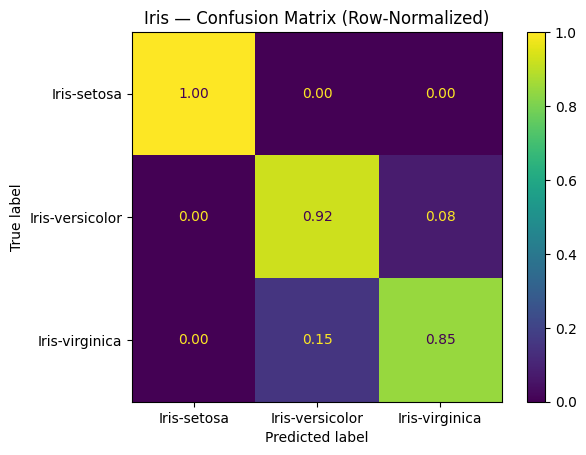

In [9]:
cm_norm = confusion_matrix(y_test, y_pred, labels=list(range(len(classes))), normalize="true")
ConfusionMatrixDisplay(cm_norm, display_labels=classes).plot(values_format=".2f")
plt.title("Iris — Confusion Matrix (Row-Normalized)")
plt.show()



### 8.2 Top-$k$ accuracy on Iris


In [10]:
for k in [1, 2, 3]:
    print(f"Top-{k} accuracy:", top_k_accuracy_score(y_test, P_test, k=k, labels=list(range(len(classes)))))


Top-1 accuracy: 0.9210526315789473
Top-2 accuracy: 1.0
Top-3 accuracy: 1.0


C:\Users\LENOVO.PIESC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_ranking.py:2025: UndefinedMetricWarning: 'k' (3) greater than or equal to 'n_classes' (3) will result in a perfect score and is therefore meaningless.
  warnings.warn(



### 8.3 Decision regions on a 2D slice

We visualize decision regions using two features:
`petal_length` and `petal_width`.


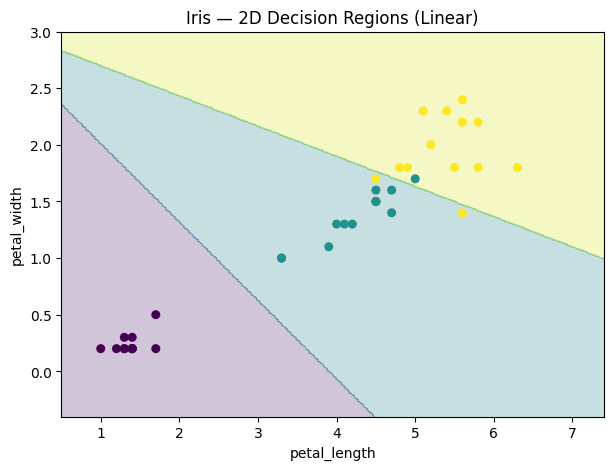

In [11]:
feat_x, feat_y = "petal_length", "petal_width"
X2 = df_iris[[feat_x, feat_y]]
y2 = y_id

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, random_state=42, stratify=y2
)

pipe_2d = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, solver="lbfgs"))
])
pipe_2d.fit(X2_train, y2_train)

x_min, x_max = X2[feat_x].min() - 0.5, X2[feat_x].max() + 0.5
y_min, y_max = X2[feat_y].min() - 0.5, X2[feat_y].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = pd.DataFrame({feat_x: xx.ravel(), feat_y: yy.ravel()})

Z = pipe_2d.predict(grid).reshape(xx.shape)

plt.figure(figsize=(7, 5))
plt.contourf(xx, yy, Z, alpha=0.25)
plt.scatter(X2_test[feat_x], X2_test[feat_y], c=y2_test, s=30)
plt.title("Iris — 2D Decision Regions (Linear)")
plt.xlabel(feat_x)
plt.ylabel(feat_y)
plt.show()



### 8.4 Polynomial features (degree 2) to create nonlinear boundaries

By adding polynomial features, the model can represent curved boundaries in the original 2D space.
This is a classical way to increase capacity without switching model families.

Be careful:
- more features increases overfitting risk,
- evaluation must be done on a held-out set or via CV.

We visualize the effect.


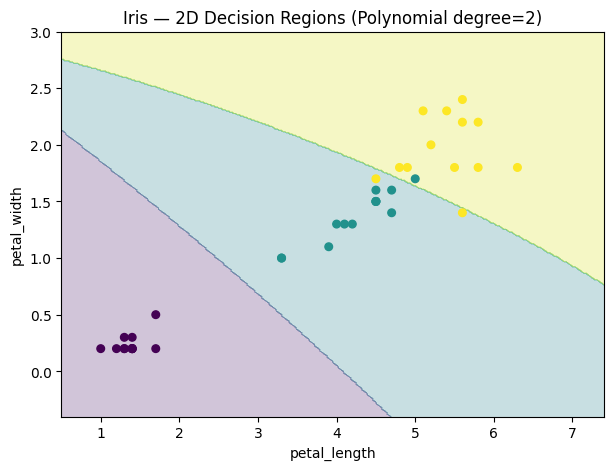

In [12]:
from sklearn.preprocessing import PolynomialFeatures

poly_pipe = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=7000, solver="lbfgs"))
])

poly_pipe.fit(X2_train, y2_train)
Z_poly = poly_pipe.predict(grid).reshape(xx.shape)

plt.figure(figsize=(7, 5))
plt.contourf(xx, yy, Z_poly, alpha=0.25)
plt.scatter(X2_test[feat_x], X2_test[feat_y], c=y2_test, s=30)
plt.title("Iris — 2D Decision Regions (Polynomial degree=2)")
plt.xlabel(feat_x)
plt.ylabel(feat_y)
plt.show()



## 9) From scratch: gradient descent for multinomial logistic regression

Implementing training once solidifies your understanding of:

- softmax probabilities,
- cross-entropy,
- and how gradients move weights.

We keep the implementation vectorized and include L2 regularization.

Note: for real work, use library solvers; GD here is purely educational.


In [13]:
def softmax_stable(Z, axis=1):
    Z = np.asarray(Z)
    Z_max = np.max(Z, axis=axis, keepdims=True)
    expZ = np.exp(Z - Z_max)
    return expZ / np.sum(expZ, axis=axis, keepdims=True)

def multiclass_log_loss(y_true, P_pred, eps=1e-15):
    y_true = np.asarray(y_true)
    P_pred = np.asarray(P_pred)
    P_pred = np.clip(P_pred, eps, 1 - eps)
    n = y_true.shape[0]
    return -np.mean(np.log(P_pred[np.arange(n), y_true]))

def one_hot(y, K):
    y = np.asarray(y)
    Y = np.zeros((y.shape[0], K), dtype=float)
    Y[np.arange(y.shape[0]), y] = 1.0
    return Y

def train_multinomial_logreg_gd(X, y, lr=0.1, n_steps=2000, l2=1e-4, seed=0):
    rng = np.random.default_rng(seed)
    n, d = X.shape
    K = int(np.max(y)) + 1

    W = 0.01 * rng.standard_normal((d, K))
    b = np.zeros(K)
    Y = one_hot(y, K)

    history = []
    for step in range(n_steps):
        Z = X @ W + b
        P = softmax_stable(Z, axis=1)

        loss = multiclass_log_loss(y, P) + 0.5 * l2 * np.sum(W * W)

        dZ = (P - Y) / n
        dW = X.T @ dZ + l2 * W
        db = np.sum(dZ, axis=0)

        W -= lr * dW
        b -= lr * db

        if step % 200 == 0 or step == n_steps - 1:
            history.append((step, loss))
    return W, b, history

X_mat = df_iris.drop(columns=["classification"]).to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mat)

W_gd, b_gd, hist = train_multinomial_logreg_gd(X_scaled, y_id, lr=0.2, n_steps=2000, l2=1e-3)
hist[:4], hist[-1]


([(0, np.float64(1.0979993490235294)),
  (200, np.float64(0.2025882207338777)),
  (400, np.float64(0.1530140455916484)),
  (600, np.float64(0.13310114829339312))],
 (1999, np.float64(0.10610945751570872)))

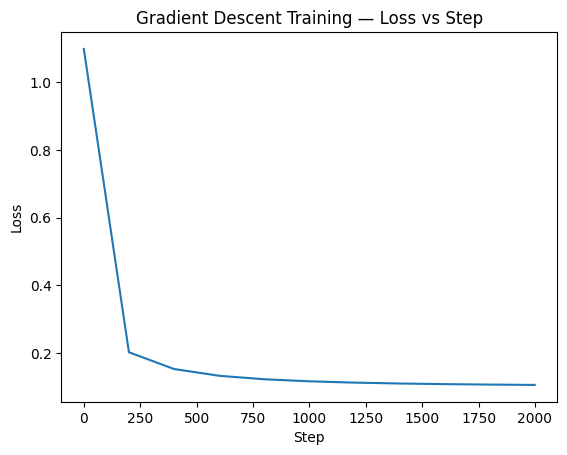

In [14]:
steps = [h[0] for h in hist]
losses = [h[1] for h in hist]

plt.plot(steps, losses)
plt.title("Gradient Descent Training — Loss vs Step")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()


In [15]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_scaled, y_id, test_size=0.25, random_state=42, stratify=y_id
)

W_gd2, b_gd2, hist2 = train_multinomial_logreg_gd(X_train_s, y_train_s, lr=0.2, n_steps=3000, l2=1e-3)

P_test_gd = softmax_stable(X_test_s @ W_gd2 + b_gd2, axis=1)
y_pred_gd = np.argmax(P_test_gd, axis=1)

print("From-scratch accuracy:", accuracy_score(y_test_s, y_pred_gd))
print("From-scratch log-loss:", multiclass_log_loss(y_test_s, P_test_gd))


From-scratch accuracy: 0.9473684210526315
From-scratch log-loss: 0.1170769956217721



## 10) Example B — Drug200 (mixed categorical + numeric)

This dataset demonstrates why pipelines matter:

- categorical columns need one-hot encoding,
- numeric columns benefit from scaling,
- all transforms must be learned on training data only.

We build a `ColumnTransformer` + `Pipeline` and report multiple metrics.


In [16]:
df_drug = pd.read_csv("../../../Datasets/Classification/drug200.csv")
display(df_drug.head())
print(df_drug.shape)
print(df_drug["Drug"].value_counts())


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


(200, 6)
Drug
DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64


In [17]:
X = df_drug.drop(columns=["Drug"])
y = df_drug["Drug"]

classes = sorted(y.unique())
class_to_id = {c:i for i,c in enumerate(classes)}
y_id = y.map(class_to_id).to_numpy()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

pipe_drug = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=8000, solver="lbfgs"))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_id, test_size=0.25, random_state=7, stratify=y_id
)

pipe_drug.fit(X_train, y_train)
y_pred = pipe_drug.predict(X_test)
P_test = pipe_drug.predict_proba(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("Log-loss:", log_loss(y_test, P_test, labels=list(range(len(classes)))))

print(classification_report(y_test, y_pred, target_names=classes, digits=4))


Accuracy: 0.96
Balanced accuracy: 0.941304347826087
Macro F1: 0.9301709401709403
Log-loss: 0.3152752547121382
              precision    recall  f1-score   support

       DrugY     1.0000    0.9565    0.9778        23
       drugA     0.8571    1.0000    0.9231         6
       drugB     0.7500    0.7500    0.7500         4
       drugC     1.0000    1.0000    1.0000         4
       drugX     1.0000    1.0000    1.0000        13

    accuracy                         0.9600        50
   macro avg     0.9214    0.9413    0.9302        50
weighted avg     0.9629    0.9600    0.9605        50




### 10.1 Cross-validation with multiple metrics

Use `cross_validate` to estimate performance more robustly than a single split.

We compute:
- accuracy,
- balanced accuracy,
- macro-F1,
- negative log-loss.


In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

scoring = {
    "acc": "accuracy",
    "bal_acc": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "neg_log_loss": "neg_log_loss",
}

cv_res = cross_validate(pipe_drug, X, y_id, cv=cv, scoring=scoring)
df_cv = pd.DataFrame({k: v for k, v in cv_res.items() if k.startswith("test_")})
display(df_cv)
display(df_cv.mean())


,test_acc,test_bal_acc,test_f1_macro,test_neg_log_loss
0,0.950,0.978947,0.938889,-0.214537
1,0.950,0.968889,0.968889,-0.290611
2,0.950,0.866667,0.889474,-0.282251
3,0.975,0.988889,0.965714,-0.252933
4,0.950,0.938889,0.925714,-0.269264


test_acc             0.955000
test_bal_acc         0.948456
test_f1_macro        0.937736
test_neg_log_loss   -0.261919
dtype: float64


### 10.2 Uncertainty via entropy (triage signal)

For probabilities $\mathbf{p}$ over $K$ classes:

$$
H(\mathbf{p}) = -\sum_{k=1}^{K} p_k \log p_k
$$

Entropy can support:
- abstention (“send to human”),
- active learning (label the most uncertain samples),
- drift detection (average entropy rises).

We compute entropy on Drug200 test predictions and inspect uncertain cases.


In [19]:
def prob_entropy(P, eps=1e-15):
    P = np.clip(P, eps, 1.0)
    return -np.sum(P * np.log(P), axis=1)

ent = prob_entropy(P_test)
df_unc = X_test.copy().reset_index(drop=True)
df_unc["y_true"] = y_test
df_unc["y_pred"] = y_pred
df_unc["entropy"] = ent
display(df_unc.sort_values("entropy", ascending=False).head(10))


,Age,Sex,BP,Cholesterol,Na_to_K,y_true,y_pred,entropy
21,53,F,HIGH,NORMAL,12.495,2,2,1.376408
48,60,F,HIGH,HIGH,13.303,2,2,1.320894
11,55,F,HIGH,HIGH,10.977,2,1,1.288518
22,57,F,HIGH,NORMAL,9.945,2,2,1.184212
34,69,M,LOW,HIGH,15.478,0,0,1.154084
14,38,F,HIGH,NORMAL,11.326,1,1,1.124034
3,49,M,HIGH,NORMAL,6.269,1,1,1.076996
43,72,F,LOW,NORMAL,14.642,4,4,1.072033
25,26,F,LOW,HIGH,14.160,3,3,1.055539
33,23,M,NORMAL,HIGH,12.260,4,4,1.050539



## 11) Example C — Stars: imbalance and `class_weight`

When classes are imbalanced, accuracy can look good while minority recall is poor.

Two quick actions:

1. Report macro-F1 and per-class recall.
2. Try `class_weight="balanced"` and compare macro-F1 / log-loss.

We train default vs balanced and compare.


In [20]:
df_stars = pd.read_csv("../../../Datasets/Classification/stars.csv")
display(df_stars.head())
print(df_stars.shape)
print(df_stars["Type"].value_counts())


,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,Red Dwarf
1,3042,0.000500,0.1542,16.60,Red,M,Red Dwarf
2,2600,0.000300,0.1020,18.70,Red,M,Red Dwarf
3,2800,0.000200,0.1600,16.65,Red,M,Red Dwarf
4,1939,0.000138,0.1030,20.06,Red,M,Red Dwarf


(240, 7)
Type
Red Dwarf        40
Brown Dwarf      40
White Dwarf      40
Main Sequence    40
Super Giants     40
Hyper Giants     40
Name: count, dtype: int64


In [21]:
X = df_stars.drop(columns=["Type"])
y = df_stars["Type"]

classes = sorted(y.unique())
class_to_id = {c:i for i,c in enumerate(classes)}
y_id = y.map(class_to_id).to_numpy()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

def fit_eval(class_weight=None):
    pipe = Pipeline(steps=[
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=10000, solver="lbfgs", class_weight=class_weight))
    ])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_id, test_size=0.25, random_state=0, stratify=y_id
    )
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    P_test = pipe.predict_proba(X_test)
    return {
        "class_weight": str(class_weight),
        "accuracy": accuracy_score(y_test, y_pred),
        "macro_f1": f1_score(y_test, y_pred, average="macro"),
        "log_loss": log_loss(y_test, P_test, labels=list(range(len(classes))))
    }

display(pd.DataFrame([fit_eval(None), fit_eval("balanced")]))


,class_weight,accuracy,macro_f1,log_loss
0,None,1.0,1.0,0.248643
1,balanced,1.0,1.0,0.248643



## 12) Example D — Glass: many classes, subtle separations

This dataset is a strong test of evaluation discipline:

- multiple classes,
- overlapping regions,
- confusion structure that matters more than a single number.

We train a scaled model and compute accuracy, macro-F1, log-loss, and AUC variants.


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,building_windows_float_processed
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,building_windows_float_processed
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,building_windows_float_processed
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,building_windows_float_processed
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,building_windows_float_processed


(214, 10)
Type
building_windows_non_float_processed    76
building_windows_float_processed        70
headlamps                               29
vehicle_windows_float_processed         17
containers                              13
tableware                                9
Name: count, dtype: int64
Accuracy: 0.6296296296296297
Balanced accuracy: 0.48355263157894735
Macro F1: 0.48289312039312043
Log-loss: 0.8477218315984418


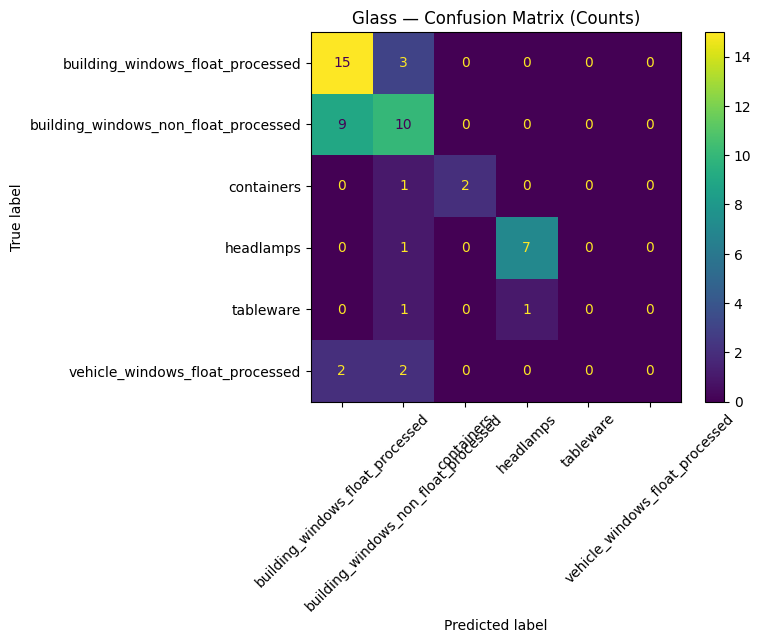

In [22]:
df_glass = pd.read_csv("../../../Datasets/Classification/glass.csv")
display(df_glass.head())
print(df_glass.shape)
print(df_glass["Type"].value_counts())

X = df_glass.drop(columns=["Type"])
y = df_glass["Type"]

classes = sorted(y.unique())
class_to_id = {c:i for i,c in enumerate(classes)}
y_id = y.map(class_to_id).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y_id, test_size=0.25, random_state=10, stratify=y_id
)

pipe_glass = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=12000, solver="lbfgs"))
])
pipe_glass.fit(X_train, y_train)

y_pred = pipe_glass.predict(X_test)
P_test = pipe_glass.predict_proba(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("Log-loss:", log_loss(y_test, P_test, labels=list(range(len(classes)))))

cm = confusion_matrix(y_test, y_pred, labels=list(range(len(classes))))
ConfusionMatrixDisplay(cm, display_labels=classes).plot(xticks_rotation=45)
plt.title("Glass — Confusion Matrix (Counts)")
plt.show()



### 12.1 Multiclass ROC-AUC on Glass (OvR and OvO)

AUC is computed from probabilities. We compute several common reductions.

Note: AUC answers a “ranking” question; it does not guarantee calibrated probabilities.


In [23]:
auc_ovr_macro = roc_auc_score(y_test, P_test, multi_class="ovr", average="macro")
auc_ovr_weighted = roc_auc_score(y_test, P_test, multi_class="ovr", average="weighted")
auc_ovo_macro = roc_auc_score(y_test, P_test, multi_class="ovo", average="macro")

print("ROC-AUC OvR macro:", auc_ovr_macro)
print("ROC-AUC OvR weighted:", auc_ovr_weighted)
print("ROC-AUC OvO macro:", auc_ovo_macro)


ROC-AUC OvR macro: 0.8958487537597745
ROC-AUC OvR weighted: 0.8280516951815616
ROC-AUC OvO macro: 0.9091130604288499



## 13) Probability calibration sanity check (confidence binning)

We build a simple confidence vs accuracy table:

- confidence = max probability
- bin by confidence
- compare avg confidence to empirical accuracy

Perfect calibration implies avg_confidence ≈ empirical_accuracy in each bin.


In [24]:
def confidence_accuracy_table(y_true, P_pred, n_bins=10):
    y_true = np.asarray(y_true)
    P_pred = np.asarray(P_pred)
    conf = P_pred.max(axis=1)
    y_hat = P_pred.argmax(axis=1)
    correct = (y_hat == y_true).astype(int)

    bins = np.linspace(0, 1, n_bins + 1)
    rows = []
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (conf >= lo) & (conf < hi) if i < n_bins-1 else (conf >= lo) & (conf <= hi)
        if mask.sum() == 0:
            continue
        rows.append({
            "bin": f"[{lo:.1f}, {hi:.1f}]",
            "count": int(mask.sum()),
            "avg_confidence": float(conf[mask].mean()),
            "empirical_accuracy": float(correct[mask].mean())
        })
    return pd.DataFrame(rows)

display(confidence_accuracy_table(y_test, P_test, n_bins=10))


,bin,count,avg_confidence,empirical_accuracy
0,"[0.3, 0.4]",2,0.378804,0.000000
1,"[0.4, 0.5]",12,0.455623,0.583333
2,"[0.5, 0.6]",14,0.551752,0.571429
3,"[0.6, 0.7]",10,0.650284,0.700000
4,"[0.7, 0.8]",6,0.763464,0.500000
5,"[0.8, 0.9]",3,0.823216,0.666667
6,"[0.9, 1.0]",7,0.985614,1.000000



## 14) Cost-sensitive decisioning (when mistakes have unequal costs)

Many real problems are not “all mistakes equal”.

Define a cost matrix $C$ where $C_{i,j}$ is the cost of predicting $j$ when truth is $i$.

Given predicted probabilities $\hat{\mathbf{p}}(x)$, the minimum expected cost decision is:

$$
\hat{y}(x) = \arg\min_j \sum_i C_{i,j}\, p(y=i\mid x)
$$

This generalizes thresholding.

Below we demonstrate a toy cost matrix on Glass. Replace this with your domain cost model.


In [25]:
# Toy cost-sensitive decision demo on Glass test set
K = P_test.shape[1]

# Cost matrix: 0 on diagonal, 1 off-diagonal by default
C = np.ones((K, K)) - np.eye(K)

# Make one particular confusion more costly (example)
if K >= 2:
    C[0, 1] = 3.0  # true class 0 predicted as 1 costs 3
    C[1, 0] = 3.0  # symmetric, for illustration

expected_cost = P_test @ C.T
y_cost_pred = np.argmin(expected_cost, axis=1)

print("Argmax accuracy:", accuracy_score(y_test, y_pred))
print("Cost-sensitive accuracy:", accuracy_score(y_test, y_cost_pred))


Argmax accuracy: 0.6296296296296297
Cost-sensitive accuracy: 0.4444444444444444



## Appendix A — Interpreting multiclass logistic regression (coefficients, odds, and limits)

People often say “logistic regression is interpretable,” which is true in a qualified sense.
For multiclass logistic regression, interpretation is slightly more subtle than the binary case.

### 8.1 What a coefficient means in the multinomial model

In the multinomial softmax model, each class $k$ has its own weight vector $\mathbf{w}_k$.
Changing a feature $x_j$ changes **all** logits:

$$
z_k = \sum_{j=1}^{d} w_{j,k} x_j + b_k
$$

So a single feature influences the relative probability between classes.
A common interpretability lens is the **log-odds ratio between two classes**.

Between classes $a$ and $b$:

$$
\log\frac{p(y=a\mid x)}{p(y=b\mid x)} = ( \mathbf{w}_a - \mathbf{w}_b )^\top x + (b_a - b_b)
$$

This is a key result:

- The *difference* of class weight vectors controls the log-odds between those two classes.
- If feature $x_j$ increases, the log-odds shift by $(w_{j,a}-w_{j,b})$ per unit change (holding other features fixed).

This is why “interpretation” in multiclass is about comparisons:
- “feature $j$ pushes the example toward class A relative to class B.”

### 8.2 Scaling and encoding are part of interpretation

Coefficients are meaningful only after you account for preprocessing:

- If you standardize features, a unit change means “one standard deviation,” not “one raw unit.”
- If you one-hot encode a categorical variable, the coefficient corresponds to a specific category indicator.

Therefore, in real tabular pipelines, interpretation requires:

1. retrieving the transformed feature names (especially after one-hot),
2. understanding the scaling applied to numeric columns,
3. knowing how the library parameterizes the multinomial model.

### 8.3 What about “odds ratios”?

In binary logistic regression, you often report an odds ratio $e^{w_j}$ for a unit increase in $x_j$.
In multiclass, you can still compute odds ratios, but they are typically defined between **pairs** of classes:

$$
\frac{p(a\mid x)}{p(b\mid x)} \propto \exp\left((\mathbf{w}_a-\mathbf{w}_b)^\top x\right)
$$

So you might say:

- “a one-unit increase in $x_j$ multiplies the odds of A vs B by $\exp(w_{j,a}-w_{j,b})$.”

This is valid, but you must specify **which pair** of classes you are comparing.

### 8.4 Limits of interpretability

Even when coefficients are “interpretable,” several things can complicate the story:

- correlated features (multicollinearity) can distribute weight across columns unpredictably,
- one-hot expansion can create many correlated indicators (especially with rare categories),
- regularization changes coefficients substantially (often for the better, but interpretation changes),
- linear decision boundaries may be a poor fit for the true data-generating process.

Practical recommendation:

- Use coefficient inspection as a *debugging aid*, not as the only explanation tool.
- Combine it with error analysis, partial dependence (when appropriate), and domain knowledge.



## Appendix B — Decisioning patterns in multiclass systems (thresholds, top-k, abstention)

Once you have probabilities, you can do more than “predict the argmax class.”

### 9.1 Thresholding in multiclass

In binary classification, thresholding is straightforward (predict positive if $p\ge \tau$).
In multiclass, you have several options:

- **Global threshold on max probability**: predict argmax if $\max_k p_k \ge \tau$, otherwise abstain.
- **Per-class thresholds**: each class has its own threshold $\tau_k$ (useful when costs differ by class).
- **Top-k surfacing**: instead of a single class, return top 2–3 candidates to a human/system.

These options are not mutually exclusive.

### 9.2 Abstention and coverage tradeoffs

An abstention policy typically increases accuracy on the covered subset (predictions you keep),
but reduces coverage (fraction of samples you decide on automatically).

This tradeoff is often desirable:

- In high-stakes settings, you may prefer lower automation but higher reliability.
- In customer-support routing, you may send uncertain cases to a human queue.

This is where entropy and calibration diagnostics become operationally valuable.

### 9.3 Cost-sensitive decisioning is the general case

Thresholds and top-k are heuristics.
The most principled approach is cost-sensitive decisioning:

- define a cost matrix,
- choose the class that minimizes expected cost under the predicted probability distribution.

This cleanly handles cases like:
- “misclassifying class A as B costs 10× more than as C.”

If you do not have a cost model, your system is implicitly assuming all mistakes are equal—which is often false.



## Appendix C — Model selection and tuning for softmax logistic regression (practical playbook)

Even though logistic regression is “simple,” it still has hyperparameters that affect performance and calibration.

### 10.1 Regularization strength (`C`)

`C` controls the bias–variance tradeoff:

- small `C` (strong regularization) reduces variance but can underfit,
- large `C` (weak regularization) fits training data more closely but can overfit and become overconfident.

A professional workflow:

- define a grid of `C` values on a log scale (e.g., 1e-3 to 1e3),
- select using cross-validated log-loss or macro-F1 (depending on your objective),
- then evaluate once on a final test set.

### 10.2 Solver choice

- `lbfgs` is a strong default for multinomial models on small/medium data.
- `saga` is useful when you need L1 / elastic net regularization or very large datasets.
- `liblinear` is often used for OvR and can be slower for some multiclass configurations.

If you change solver, you should re-check:

- convergence,
- and probability calibration.

### 10.3 Class weights and imbalance

`class_weight="balanced"` reweights the loss so that each class contributes roughly equally.
This often improves macro metrics at the expense of raw accuracy.

Do not treat it as a free lunch:
- it changes the implied objective,
- and can change calibration.

Evaluate with the metric that matches your deployment goal.

### 10.4 Feature engineering vs model complexity

Before switching models, ask:

- Is the failure due to nonlinearity?  
  (Try polynomial features or interactions, or move to a nonlinear model.)
- Is the failure due to missing predictors?  
  (Collect better data or engineer better features.)
- Is the failure due to label noise or ambiguity?  
  (Improve label quality and guidelines.)

A common pattern: 80% of gains come from data and features, not from switching the classifier.



## Appendix D — Reproducibility checklist (for a GitHub tutorial repo)

Since you are building a tutorial repository, reproducibility is part of the product.

Minimum checklist:

- Fix random seeds in splits (`random_state=...`).
- Use `Pipeline` so preprocessing is attached to the estimator.
- Log dataset paths and the exact target column name.
- Print class distributions for train/test.
- Report multiple metrics (accuracy + macro-F1 + log-loss).
- Store the label mapping (`class_to_id`) and reuse it for inference.

If you follow this, readers can run the notebook and get consistent results.



## Appendix E — Computational considerations (when $d$ and $K$ grow)

In tutorials, softmax regression looks trivial. In production, two scaling dimensions matter:

- $d$: number of features after preprocessing (especially after one-hot encoding)
- $K$: number of classes

### E.1 Parameter count and memory

The weight matrix has size $d\times K$.

- If $d=50{,}000$ (common after sparse one-hot) and $K=1{,}000$, then $dK=50$ million weights.
- In float64, that is ~400 MB just for weights; float32 halves that.
- Sparse features help in computation, but the model parameters are still dense in general.

### E.2 Training time

Each gradient/iteration involves operations like $\mathbf{X}\mathbf{W}$ and softmax normalization:

- Roughly $O(n\cdot d\cdot K)$ in dense form.
- In sparse settings, it behaves more like $O(\mathrm{nnz}(\mathbf{X})\cdot K)$.

This is why:
- feature hashing and dimensionality reduction can help,
- and why “linear” does not necessarily mean “cheap” when $K$ is large.

### E.3 Practical mitigations

- Reduce $d$: prune rare categories, use hashing, or group categories.
- Reduce $K$: collapse rare classes into “other” when appropriate.
- Use solvers designed for large-scale problems (e.g., `saga`) and consider sparse pipelines.
- Evaluate whether you actually need full probabilities over all classes (sometimes top-k retrieval is enough).

These considerations are not needed for small tutorial datasets, but they become central in real-world multiclass systems.



## Appendix F — Worked log-loss example (to build intuition)

Consider a 3-class problem with true label $y=2$.

Two models output probabilities:

- Model A: $p=[0.34, 0.33, 0.33]$ (almost uniform; low confidence)
- Model B: $p=[0.90, 0.09, 0.01]$ (high confidence, but on the wrong class)

Both models predict the argmax class:

- Model A predicts class 0 (wrong),
- Model B predicts class 0 (wrong).

So **accuracy** treats them as equally bad.

Log-loss for a single sample is:

$$
\ell = -\log p(y\mid x)
$$

Because the true class is 2:

- Model A: $\ell_A = -\log(0.33)$
- Model B: $\ell_B = -\log(0.01)$

Numerically, $\ell_B$ is much larger: the model is confidently wrong, which is dangerous if you use probabilities for decisioning.

Now compare two correct models:

- Model C: $p=[0.20, 0.20, 0.60]$
- Model D: $p=[0.01, 0.01, 0.98]$

Both predict class 2 correctly, so accuracy says both are equally good.
But log-loss prefers Model D because it assigns much higher probability to the truth.

This is why, in systems where probabilities matter, log-loss is often a more informative optimization/evaluation target than accuracy.



## 15) Common pitfalls (and how to avoid them)

1. **Preprocessing leakage**  
   - Wrong: fit scaler/encoder on all data before split/CV.  
   - Right: put preprocessing inside a `Pipeline`.

2. **Unstable label mapping**  
   - Always create an explicit `class_to_id` mapping and reuse it.

3. **Over-trusting accuracy**  
   - Always inspect confusion matrices and macro metrics.

4. **Ignoring class imbalance**  
   - Check class counts, use macro-F1, consider `class_weight="balanced"`.

5. **Convergence warnings**  
   - Scale features, increase `max_iter`, or adjust `C`.

6. **Using probabilities without calibration thinking**  
   - If probabilities drive decisions, validate calibration and thresholds.

7. **Comparing models with inconsistent splits**  
   - Use fixed seeds and/or cross-validation to make comparisons fair.



## 16) Error analysis: “confident but wrong” predictions on Glass

We inspect the top mistakes by max probability.
These examples are disproportionately valuable because they reveal:

- class overlap,
- missing features,
- or label issues.

Actionable next steps often come directly from this table.


In [26]:
X_test_copy = X_test.copy().reset_index(drop=True)
df_err = X_test_copy.copy()
df_err["y_true"] = y_test
df_err["y_pred"] = y_pred
df_err["p_max"] = P_test.max(axis=1)
df_err["is_correct"] = (df_err["y_true"] == df_err["y_pred"])

df_err["true_class"] = df_err["y_true"].map({i:c for i,c in enumerate(classes)})
df_err["pred_class"] = df_err["y_pred"].map({i:c for i,c in enumerate(classes)})

display(df_err.loc[~df_err["is_correct"]].sort_values("p_max", ascending=False).head(15)[
    ["true_class","pred_class","p_max"]
])


,true_class,pred_class,p_max
33,containers,building_windows_non_float_processed,0.818342
23,building_windows_non_float_processed,building_windows_float_processed,0.796567
40,building_windows_non_float_processed,building_windows_float_processed,0.733086
53,building_windows_non_float_processed,building_windows_float_processed,0.720228
36,vehicle_windows_float_processed,building_windows_non_float_processed,0.681058
43,building_windows_non_float_processed,building_windows_float_processed,0.657259
12,vehicle_windows_float_processed,building_windows_float_processed,0.603521
18,headlamps,building_windows_non_float_processed,0.576210
24,building_windows_non_float_processed,building_windows_float_processed,0.570316
26,building_windows_non_float_processed,building_windows_float_processed,0.559344



## 17) Benchmark table across datasets (consistent reporting)

Finally, we generate a compact comparison table across multiple datasets:

- Iris
- Drug200
- Stars
- Glass

We report:
- accuracy,
- macro-F1,
- log-loss.

This is a strong baseline reporting format for tabular multiclass tasks.


In [27]:
def evaluate_multiclass(df, target_col, random_state=0):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    classes = sorted(y.unique())
    class_to_id = {c:i for i,c in enumerate(classes)}
    y_id = y.map(class_to_id).to_numpy()

    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]

    if len(cat_cols) > 0:
        preprocess = ColumnTransformer(
            transformers=[
                ("num", StandardScaler(), num_cols),
                ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
            ]
        )
        model = Pipeline(steps=[
            ("prep", preprocess),
            ("clf", LogisticRegression(max_iter=12000, solver="lbfgs"))
        ])
    else:
        model = Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=12000, solver="lbfgs"))
        ])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_id, test_size=0.25, random_state=random_state, stratify=y_id
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    P_test = model.predict_proba(X_test)

    return {
        "n_samples": int(df.shape[0]),
        "n_classes": int(len(classes)),
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "macro_f1": float(f1_score(y_test, y_pred, average="macro")),
        "log_loss": float(log_loss(y_test, P_test, labels=list(range(len(classes)))))
    }

df_iris = pd.read_csv("../../../Datasets/Classification/iris.csv")
df_drug = pd.read_csv("../../../Datasets/Classification/drug200.csv")
df_stars = pd.read_csv("../../../Datasets/Classification/stars.csv")
df_glass = pd.read_csv("../../../Datasets/Classification/glass.csv")

rows = []
rows.append(("iris", evaluate_multiclass(df_iris, "classification", random_state=42)))
rows.append(("drug200", evaluate_multiclass(df_drug, "Drug", random_state=7)))
rows.append(("stars", evaluate_multiclass(df_stars, "Type", random_state=0)))
rows.append(("glass", evaluate_multiclass(df_glass, "Type", random_state=10)))

df_bench = pd.DataFrame([{**{"dataset": name}, **metrics} for name, metrics in rows])
display(df_bench)


,dataset,n_samples,n_classes,accuracy,macro_f1,log_loss
0,iris,150,3,0.921053,0.922963,0.209986
1,drug200,200,5,0.960000,0.930171,0.315275
2,stars,240,6,1.000000,1.000000,0.248643
3,glass,214,6,0.629630,0.482893,0.847722



## 18) Summary

You now have an end-to-end workflow for multiclass softmax logistic regression:

- Understand the model: logits + softmax probabilities.
- Understand training: maximize likelihood / minimize cross-entropy (log-loss).
- Implement stable softmax/log-softmax to avoid numerical failure.
- Use pipelines: scale numeric features, one-hot encode categorical features, avoid leakage.
- Evaluate properly:
  - confusion matrices,
  - macro-F1 (and per-class metrics),
  - log-loss (probability quality),
  - AUC (ranking quality),
  - calibration checks,
  - and cost-sensitive decisioning when your domain demands it.

This workflow generalizes to many other multiclass models: the evaluation discipline stays the same.



## 19) Exercises

### Exercise 1 — Manual metric computation from a confusion matrix

1. Compute a confusion matrix for Glass.
2. From the matrix, manually compute per-class precision and recall for two classes.
3. Verify your values match `classification_report`.

### Exercise 2 — Improve macro-F1 (feature engineering vs class weights)

On Glass:

- Try `class_weight="balanced"`.
- Try polynomial features on a subset of features (careful: high-dimensional explosion).
- Compare macro-F1 and log-loss.
- Which strategy improves minority classes most?

### Exercise 3 — Thresholding and abstention policy

For Glass:

- Predict argmax only if max probability ≥ τ.
- Otherwise abstain.

Report:
- coverage,
- accuracy on non-abstained predictions,
- average confidence.

Try several τ values and discuss the tradeoff.

### Exercise 4 — Compare OvR vs multinomial (advanced)

Train OvR logistic regression and compare:

- macro-F1,
- log-loss,
- calibration binning table.

When does OvR behave better in your experiments?

### Exercise 5 — Mini-project: reproducible evaluation report

Pick one dataset and produce a short report (as markdown in the notebook):

- EDA summary (class counts, missing values, feature types)
- chosen preprocessing pipeline
- cross-validated metrics (mean ± std)
- confusion matrix + top confident errors
- next steps you would try (data, features, model)

The goal is not to maximize accuracy; it is to practice professional evaluation and debugging.
